In [1]:
import os
import math
import time
import emcee
import corner
import logging
import traceback
import numpy as np
import pandas as pd
from multiprocessing import Pool
from joblib import Parallel,delayed

from mcmc import lnlike
from mock_cmd import MockCMD
import matplotlib.pyplot as plt
plt.style.use("default")

# logfile in total.log

isochrones_dir = '/home/shenyueyue/Projects/Cluster/data/isocForMockCMD/'

In [2]:
# read smaple_obs
name = 'Melotte_22'
usecols = ['Gmag','G_BPmag','G_RPmag','phot_g_n_obs','phot_bp_n_obs','phot_rp_n_obs']
sample_obs = pd.read_csv("/home/shenyueyue/Projects/Cluster/data/Cantat-Gaudin_2020/%s.csv"%(name), usecols=usecols)
sample_obs = sample_obs.dropna().reset_index(drop=True)

# MCMC
n_stars = len(sample_obs)
step = (0.05, 0.2)
# parameter
theta_part = np.array([7.80,0.03]) # after round theta = (8.00, 0.0)  Dias+,2021:8.116,0.032 Cantat-Gaudin+,2020:7.89
scale = np.array([1, 1])
ndim = 2

# set up the MCMC sampler
nwalkers = 150
# define the step sizes for each parameter
# moves = [emcee.moves.StretchMove(a=step_sizes[i]) for i in range(ndim)]
# create an array of initial positions with small random perturbations
p0 = np.round((theta_part + scale * np.random.randn(nwalkers, ndim)), decimals=2)

# parallelization
with Pool(50) as pool:   
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(n_stars, step, sample_obs), pool=pool) # , moves=moves
    # burn-in
    nburn = 5000
    start_burn = time.time()
    sampler.run_mcmc(p0, nburn, progress=True)
    end_burn = time.time()
    time_burn = end_burn - start_burn

samples = sampler.chain[:, :, :].reshape((-1, ndim))
figure = corner.corner(samples,
    labels=[r'log(age)',r'[M/H]',r'$f_b$',r'DM'],
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True, 
        title_kwargs={"fontsize": 12},
        title_fmt = '.2f')
corner.overplot_points(figure,p0)

fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["log(age)", "mh"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number")

  1%|          | 50/5000 [00:48<1:06:22,  1.24it/s]/home/shenyueyue/Packages/miniconda3/envs/mcmc/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/shenyueyue/Packages/miniconda3/envs/mcmc/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/shenyueyue/Packages/miniconda3/envs/mcmc/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
 14%|█▍        | 718/5000 [07:04<39:18,  1.82it/s]  /home/shenyueyue/Packages/miniconda3/envs/mcmc/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/shenyueyue/Packages/minicon

ValueError: At least one parameter value was infinite

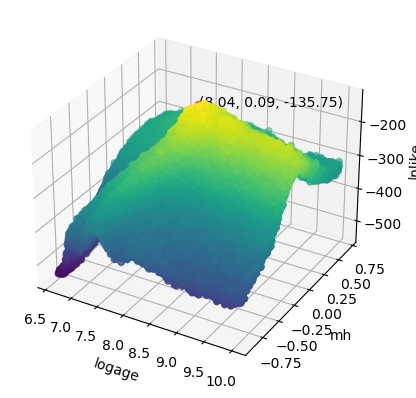

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use("default")
# 读取数据
data = pd.read_csv("/home/shenyueyue/Projects/Cluster/data/lnlike_distribution.csv")

# 提取数据列
logage = data['logage']
mh = data['mh']
lnlike = data['lnlike']

# 创建三维图形对象
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制三维散点图
ax.scatter(logage, mh, lnlike, c=lnlike, cmap='viridis')

# 找到lnlike最大值的索引
max_index = np.argmax(lnlike)
max_logage = logage[max_index]
max_mh = mh[max_index]
max_lnlike = lnlike[max_index]

# 绘制最大lnlike的点
ax.scatter(max_logage, max_mh, max_lnlike, c='red', s=50)

# 添加坐标信息标签
label = f'({max_logage:.2f}, {max_mh:.2f}, {max_lnlike:.2f})'
ax.text(max_logage, max_mh, max_lnlike, label, color='black', fontsize=10)

# 设置坐标轴标签
ax.set_xlabel('logage')
ax.set_ylabel('mh')
ax.set_zlabel('lnlike')

# 显示图形
plt.show()

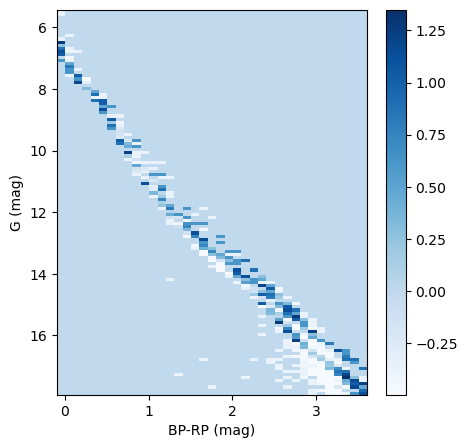

In [12]:
import numpy as np
import pandas as pd
from mock_cmd import MockCMD
import matplotlib.pyplot as plt

name = 'Melotte_22'
usecols = ['Gmag','G_BPmag','G_RPmag','phot_g_n_obs','phot_bp_n_obs','phot_rp_n_obs']
isochrones_dir = '/home/shenyueyue/Projects/Cluster/data/isocForMockCMD/'
sample_obs = pd.read_csv("/home/shenyueyue/Projects/Cluster/data/Cantat-Gaudin_2020/%s.csv"%(name), usecols=usecols)
sample_obs = sample_obs.dropna().reset_index(drop=True)
theta = (8.04,0.09,0.35,5.55)
n_stars=len(sample_obs)
step=(0.01,0.01)
m = MockCMD(sample_obs=sample_obs,isochrones_dir=isochrones_dir)
sample_syn = m.mock_stars(theta,n_stars,step)
c_syn, m_syn = MockCMD.extract_CMD(sample_syn, band_a='Gmag_syn', band_b='G_BPmag_syn', band_c='G_RPmag_syn')
c_obs, m_obs = MockCMD.extract_CMD(sample_obs, band_a='Gmag', band_b='G_BPmag', band_c='G_RPmag')
c_grid, m_grid=(min(c_obs), max(c_obs), 0.1), (min(m_obs), max(m_obs), 0.1)
H_obs, x_edges, y_edges = MockCMD.hist2d_norm(c=c_obs, m=m_obs, c_grid=c_grid, m_grid=m_grid)
H_syn, x_edges, y_edges = MockCMD.hist2d_norm(c=c_syn, m=m_syn, c_grid=c_grid, m_grid=m_grid)

# 固定 H_syn, H=H_obs
def lnlike(H):
    chi2 = np.sum( np.square(H - H_syn) / (H + H_syn + 1) )
    return -0.5*chi2

# 定义计算数值梯度的函数, 固定 H_syn
def compute_gradient(H, epsilon=1e-6):
    gradient = np.zeros_like(H)
    base_lnlike = lnlike(H)

    # 遍历H数组中的每个元素
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            # 增加一个小的扰动
            H_perturbed = H.copy()
            H_perturbed[i, j] += epsilon

            # 计算扰动后的lnlike
            perturbed_lnlike = lnlike(H_perturbed)

            # 计算梯度
            gradient[i, j] = (perturbed_lnlike - base_lnlike) / epsilon

    return gradient

# 计算数值梯度
gradient = compute_gradient(H=H_obs)


fig, ax = plt.subplots(figsize=(5, 5))
pcm = ax.pcolormesh(x_edges, y_edges, gradient.T, cmap='Blues')
#ax.scatter(c_obs,m_obs,s=2,c='grey')
plt.colorbar(pcm, ax=ax)
ax.set_xlabel('BP-RP (mag)')
ax.set_ylabel('G (mag)')
ax.invert_yaxis()

# 显示图形
plt.show()

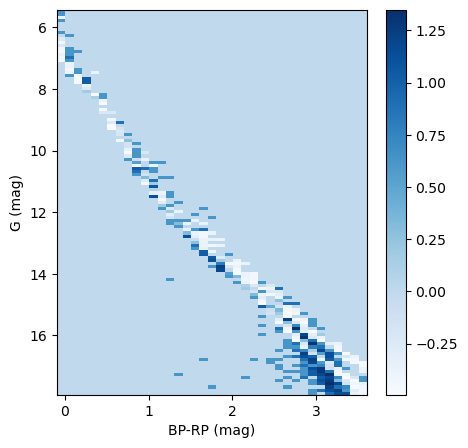

In [13]:
import numpy as np
import pandas as pd
from mock_cmd import MockCMD
import matplotlib.pyplot as plt

name = 'Melotte_22'
usecols = ['Gmag','G_BPmag','G_RPmag','phot_g_n_obs','phot_bp_n_obs','phot_rp_n_obs']
isochrones_dir = '/home/shenyueyue/Projects/Cluster/data/isocForMockCMD/'
sample_obs = pd.read_csv("/home/shenyueyue/Projects/Cluster/data/Cantat-Gaudin_2020/%s.csv"%(name), usecols=usecols)
sample_obs = sample_obs.dropna().reset_index(drop=True)
theta = (8.04,0.09,0.35,5.55)
n_stars=len(sample_obs)
step=(0.01,0.01)
m = MockCMD(sample_obs=sample_obs,isochrones_dir=isochrones_dir)
sample_syn = m.mock_stars(theta,n_stars,step)
c_syn, m_syn = MockCMD.extract_CMD(sample_syn, band_a='Gmag_syn', band_b='G_BPmag_syn', band_c='G_RPmag_syn')
c_obs, m_obs = MockCMD.extract_CMD(sample_obs, band_a='Gmag', band_b='G_BPmag', band_c='G_RPmag')
c_grid, m_grid=(min(c_obs), max(c_obs), 0.1), (min(m_obs), max(m_obs), 0.1)
H_obs, x_edges, y_edges = MockCMD.hist2d_norm(c=c_obs, m=m_obs, c_grid=c_grid, m_grid=m_grid)
H_syn, x_edges, y_edges = MockCMD.hist2d_norm(c=c_syn, m=m_syn, c_grid=c_grid, m_grid=m_grid)

# 固定 H_obs, H=H_syn
def lnlike(H):
    chi2 = np.sum( np.square(H_obs - H) / (H_obs + H + 1) )
    return -0.5*chi2

# 定义计算数值梯度的函数, 固定 H_syn
def compute_gradient(H, epsilon=1e-6):
    gradient = np.zeros_like(H)
    base_lnlike = lnlike(H)

    # 遍历H数组中的每个元素
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            # 增加一个小的扰动
            H_perturbed = H.copy()
            H_perturbed[i, j] += epsilon

            # 计算扰动后的lnlike
            perturbed_lnlike = lnlike(H_perturbed)

            # 计算梯度
            gradient[i, j] = (perturbed_lnlike - base_lnlike) / epsilon

    return gradient

# 计算数值梯度
gradient = compute_gradient(H=H_syn)


fig, ax = plt.subplots(figsize=(5, 5))
pcm = ax.pcolormesh(x_edges, y_edges, gradient.T, cmap='Blues')
#ax.scatter(c_obs,m_obs,s=2,c='grey')
plt.colorbar(pcm, ax=ax)
ax.set_xlabel('BP-RP (mag)')
ax.set_ylabel('G (mag)')
ax.invert_yaxis()

# 显示图形
plt.show()

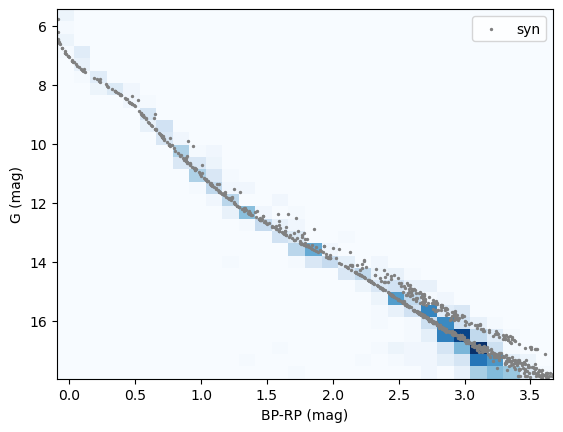

In [29]:
fig,ax = plt.subplots()
ax.hist2d(c_obs,m_obs,bins=30,cmap='Blues')
#ax.hist2d(c_syn.dropna(),m_syn.dropna(),bins=30,cmap='Blues')
ax.scatter(c_syn,m_syn,s=2,c='grey',label='syn')
ax.set_xlabel("BP-RP (mag)")
ax.set_ylabel("G (mag)")
ax.invert_yaxis()
ax.legend()